In [1]:
import pandas as pd
from datetime import datetime, timedelta

from src import *
pd.set_option('display.max_rows', None)

# Parameters

These parameters configure various things such as the relative location of data files, which date is being analysed
and the assumed generation period for an infection.

In [2]:
ALL_VIC_CASES='archive/2021-07-12/all-vic-cases.csv'
QUARANTINE='archive/2021-07-16/quarantine.csv'
GENERATION_DAYS=5

TODAY=datetime.today().strftime("%Y-%m-%d")
SAMPLE_DATE=TODAY
#SAMPLE_DATE='2021-07-23'
PREV_WEEK=(datetime.strptime(SAMPLE_DATE, "%Y-%m-%d").date()+timedelta(days=-7)).strftime("%Y-%m-%d")
PREV_FORTNIGHT=(datetime.strptime(SAMPLE_DATE, "%Y-%m-%d").date()+timedelta(days=-14)).strftime("%Y-%m-%d")

NSW_6_MONTHS=f"archive/{SAMPLE_DATE}/last-6-months-nsw.csv"
NSW_14_DAYS=f"archive/{SAMPLE_DATE}/last-14-days-nsw.csv"

# Data Preparation

**sweep_downloads()** moves files from the $HOME/Downloads directory into today's archive directory. Thses should first be
downloaded from the "Last 14 days (new)" and "Last 6 months (true)" panels of the NSW Transmission Sources section of [covid19data.com.au](https://www.covid19data.com.au/nsw)

In [3]:
sweep_downloads(TODAY)

Next, we load the data from the files and merge the 14-day data with the 6 month data.

In [4]:
nsw_df = update_df(load_data(NSW_6_MONTHS),load_data(NSW_14_DAYS))
vic_df = load_vic_data(ALL_VIC_CASES)
quarantine_df = load_quarantine(QUARANTINE)

Next, we truncate and refindex the data frames to each outbreak.

In [5]:
avalon = select_outbreak(nsw_df[(nsw_df['date'] >= '2020-12-17') & (nsw_df['date'] <= '2021-01-16')], generation_days=GENERATION_DAYS)
bondi = select_outbreak(nsw_df[(nsw_df['date'] >= '2021-06-17')], generation_days=GENERATION_DAYS)
vic_outbreak = select_outbreak(vic_df[(vic_df['date'] >= '2020-05-27') & (vic_df['date'] <= '2020-10-29')], generation_days=GENERATION_DAYS)

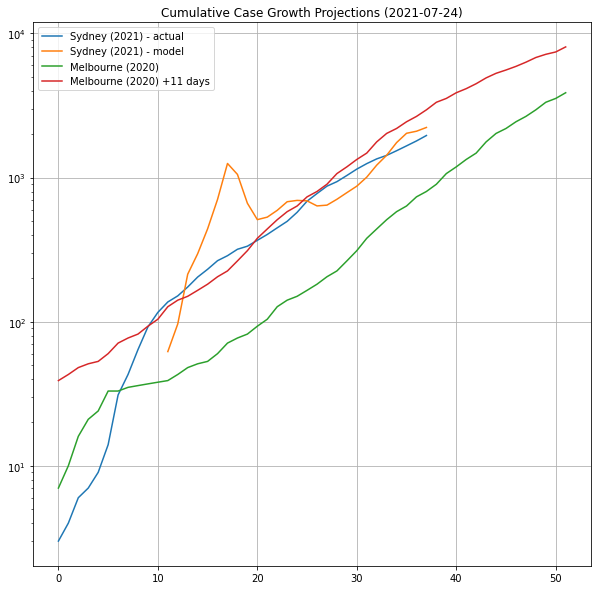

In [6]:
output=pd.DataFrame(columns=['cumulative', 'min', 'vic'])
output[['min', 'cumulative']] = bondi[['min','cumulative']]
output=output.reindex([r for r in range(0, len(bondi)+14)])
output['vic'] = vic_outbreak['cumulative']
x=11
output['vic-offset'] = vic_outbreak['cumulative'].shift(-x)
ax=output.plot(figsize=(10,10))
ax.set_yscale('log')
ax.grid()
ax.set_title(f'Cumulative Case Growth Projections ({SAMPLE_DATE})')
ax.legend([
    'Sydney (2021) - actual', 
    'Sydney (2021) - model', 
    'Melbourne (2020)',
    f'Melbourne (2020) +{x} days'
])
ax.figure.savefig(f'archive/{SAMPLE_DATE}/cumulative-partial.png')
_=_

In [7]:
%%capture cap
df=vic_outbreak
ax=df[['min', 'cumulative']].plot(figsize=(10,10))
#ax.set_yscale('log')
ax.grid()
ax.plot(bondi['cumulative'])
ax.plot(bondi['min'])
ax.legend(['model (Melbourne 2020) ', 'cumulative (Melbourne 2020)','cumulative (Sydney 2021)',  'model (Sydney 2021) '])
ax.set_title("7 Day Projection vs Actual (Melbourne 2020, Sydney 2021)")
ax.figure.savefig(f'archive/{SAMPLE_DATE}/cumulative-full.png')

_=_

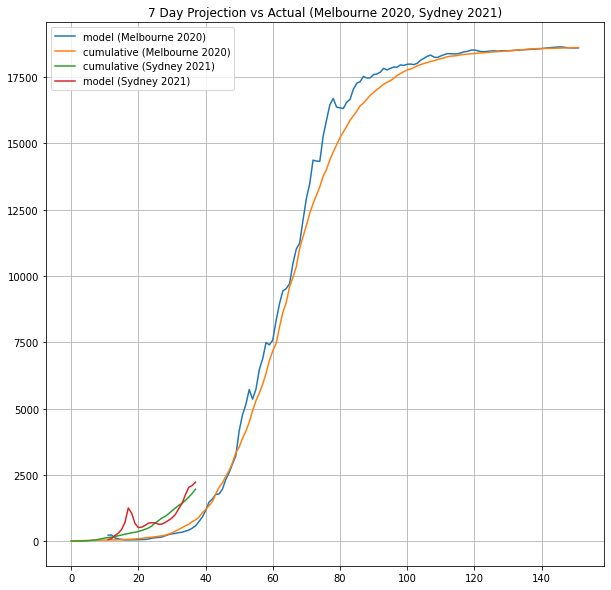

In [8]:
cap()

In [9]:
VIC_EXTRA_DAYS=40

vic_growth_params=derive_growth_params(vic_outbreak[(vic_outbreak.index >= 70) & (vic_outbreak.index < 120)], generation_days=GENERATION_DAYS)
bondi_growth_params=derive_growth_params(bondi.tail(8), generation_days=GENERATION_DAYS)
N=1
bondi_growth_params_3=derive_growth_params(bondi.tail(8+N).head(8), generation_days=GENERATION_DAYS)

bondi_projection_1=select_outbreak(project_ols_growth_rate_min(bondi, 84, vic_growth_params[1]))
bondi_projection_2=select_outbreak(project_ols_growth_rate_min(bondi, 84, bondi_growth_params[1]))
bondi_projection_3=select_outbreak(project_ols_growth_rate_min(bondi.head(len(bondi)-N), 84+N, bondi_growth_params_3[1]))


vic_partial=vic_outbreak.head(len(bondi)+VIC_EXTRA_DAYS)
vic_partial_growth_params=derive_growth_params(vic_partial)
vic_projection=select_outbreak(project_ols_growth_rate_min(vic_partial, len(vic_outbreak)-len(bondi)-VIC_EXTRA_DAYS, vic_partial_growth_params[1]), generation_days=GENERATION_DAYS)

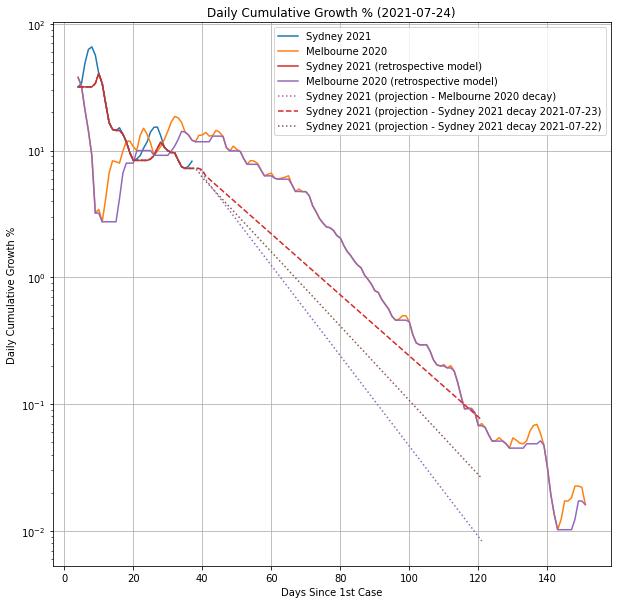

In [10]:
gp=GrowthPlot(SAMPLE_DATE)
gp.add(bondi, offset=0, legend="Sydney 2021")
#gp.add(avalon, offset=0, legend="Avalon 2020")
gp.add(vic_outbreak, offset=0, legend="Melbourne 2020")
gp.ax.plot(bondi['ols-growth-rate-min'],color="C3")
gp.ax.plot(vic_outbreak['ols-growth-rate-min'], color="C4")
gp.ax.plot(bondi_projection_1['ols-growth-rate-min'], linestyle='dotted', color='C4')
gp.ax.plot(bondi_projection_2['ols-growth-rate-min'], linestyle='dashed', color='C3')
gp.ax.plot(bondi_projection_3['ols-growth-rate-min'], linestyle='dotted', color='C5')
gp.ax.set_yscale('log')
gp.legend = gp.legend+[
    'Sydney 2021 (retrospective model)', 
    'Melbourne 2020 (retrospective model)', 
    'Sydney 2021 (projection - Melbourne 2020 decay)',
    'Sydney 2021 (projection - Sydney 2021 decay 2021-07-23)',
    'Sydney 2021 (projection - Sydney 2021 decay 2021-07-22)'
]
gp.ax.legend(gp.legend)
gp.ax.figure.savefig(f'archive/{SAMPLE_DATE}/cumulative-growth.png')

#gp.add(vic_outbreak.shift(-11), offset=0, legend="Melbourne 2020 (shifted)")
_=_

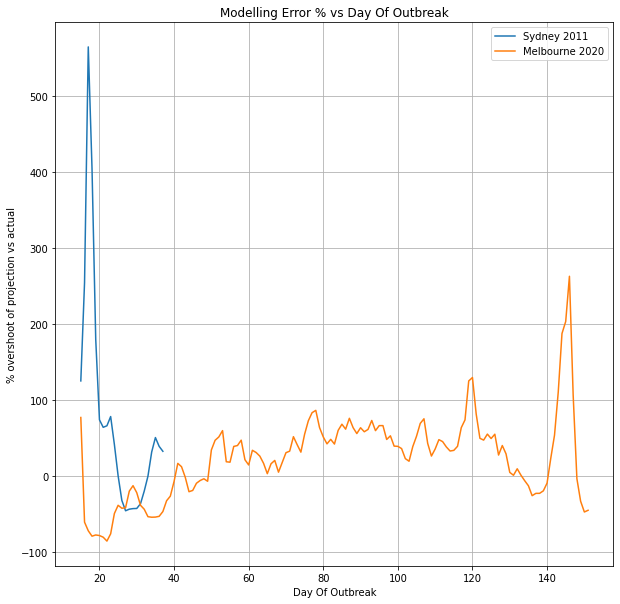

In [11]:
output=pd.DataFrame()
output['vic'] = modeling_errors(vic_outbreak)
output["vic"]
output["bondi"] = modeling_errors(bondi)
#output["avalon"] = modeling_errors(avalon)
                                    
ax=output.loc[output.index >= 15, ['bondi', 'vic', ]].plot(figsize=(10,10))
ax.grid()                         
ax.set_title("Modelling Error % vs Day Of Outbreak")
ax.set_xlabel("Day Of Outbreak")
ax.set_ylabel("% overshoot of projection vs actual")
ax.legend(['Sydney 2011', 'Melbourne 2020'])
ax.figure.savefig(f'archive/{SAMPLE_DATE}/modellng-error.png')
_=_

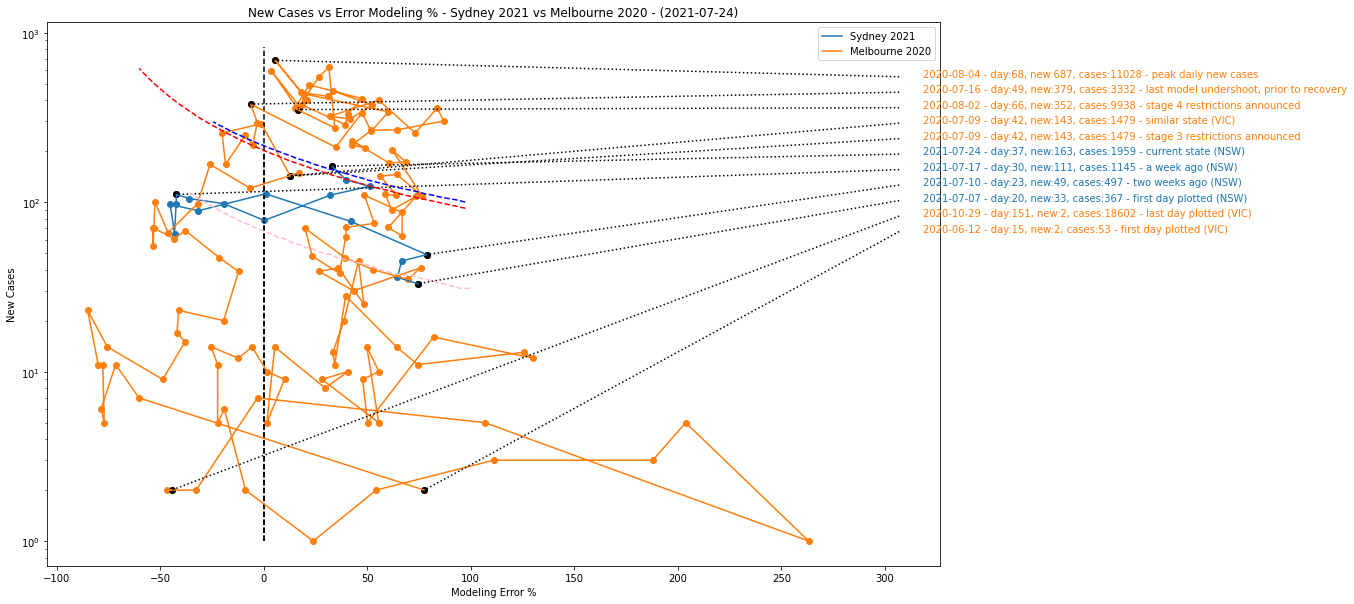

In [12]:
bondi_horizon=horizon(bondi, 7)
bondi_horizon_old=horizon(bondi.head(len(bondi)-7),7)
bondi_horizon_very_old=horizon(bondi.head(len(bondi)-14),7)

pp = PhasePlot()
bondi_idx=pp.add(bondi, offset=20, legend="Sydney 2021", color="C0") # 20
vic_idx=pp.add(vic_outbreak, offset=15, legend="Melbourne 2020", color="C1") # 15

pp.ax.set_title(f"New Cases vs Error Modeling % - Sydney 2021 vs Melbourne 2020 - ({SAMPLE_DATE})")
first_case=pp.frames[vic_idx].head(1)['date']
last_case=pp.frames[vic_idx].tail(1)[['date', 'total', 'err']]
first_case_nsw=pp.frames[bondi_idx].head(1)['date']

pp.add_label(vic_idx, "2020-08-04", "peak daily new cases")
pp.add_label(vic_idx, "2020-07-16", "last model undershoot, prior to recovery")
pp.add_label(vic_idx, "2020-08-02", "stage 4 restrictions announced")
pp.add_label(vic_idx, "2020-07-09", "similar state (VIC)")
pp.add_label(vic_idx, "2020-07-09", "stage 3 restrictions announced")
pp.add_label(bondi_idx, SAMPLE_DATE, "current state (NSW)")
pp.add_label(bondi_idx, PREV_WEEK, "a week ago (NSW)")
pp.add_label(bondi_idx, PREV_FORTNIGHT, "two weeks ago (NSW)")
pp.add_label(bondi_idx, first_case_nsw.values[0], f"first day plotted (NSW)")
pp.add_label(vic_idx, last_case.values[0][0], f"last day plotted (VIC)")
pp.add_label(vic_idx, first_case.values[0], f"first day plotted (VIC)")

# pp.add_label(vic_idx, "2020-08-09", "1 week after stage 4 restrictions announced")
# pp.add_label(vic_idx, "2020-08-16", "2 weeks after stage 4 restrictions announced")
# pp.add_label(vic_idx, "2020-08-23", "3 weeks after stage 4 restrictions announced")
# pp.add_label(vic_idx, "2020-08-30", "4 weeks after stage 4 restrictions announced")
# pp.add_label(vic_idx, "2020-09-06", "5 weeks after stage 4 restrictions announced")
# pp.add_label(vic_idx, "2020-09-13", "6 weeks after stage 4 restrictions announced")
# pp.add_label(vic_idx, "2020-09-20", "7 weeks after stage 4 restrictions announced")
# pp.add_label(vic_idx, "2020-09-27", "8 weeks after stage 4 restrictions announced")
# pp.add_label(vic_idx, "2020-10-03", "9 weeks after stage 4 restrictions announced")
# pp.add_label(vic_idx, "2020-10-10", "10 weeks after stage 4 restrictions announced")
# pp.add_label(vic_idx, "2020-10-17", "11 weeks after stage 4 restrictions announced")
# pp.add_label(vic_idx, "2020-10-24", "12 weeks after stage 4 restrictions announced")

pp.ax.plot(bondi_horizon["err"], bondi_horizon["total"], linestyle="dashed", color="blue")
pp.ax.plot(bondi_horizon_old["err"], bondi_horizon_old["total"], linestyle="dashed", color="red")
pp.ax.plot(bondi_horizon_very_old["err"], bondi_horizon_very_old["total"], linestyle="dashed", color="pink")
pp.ax.figure.savefig(f'archive/{SAMPLE_DATE}/hedgehog.png')
_=_

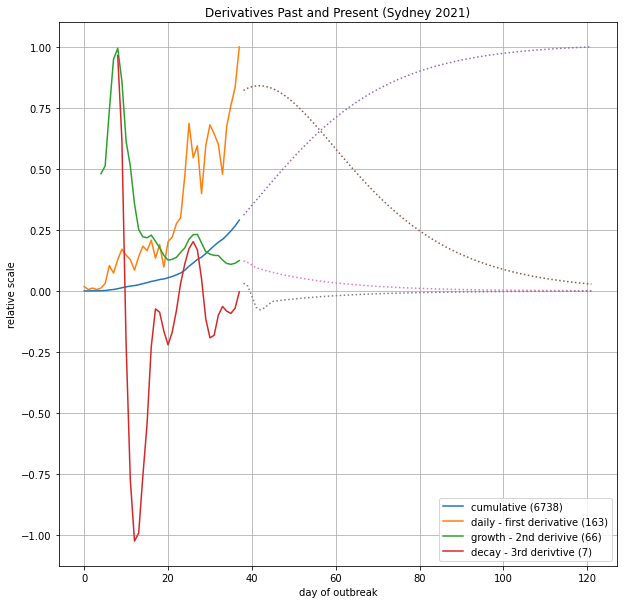

In [13]:
ax=plot_derivatives(bondi_projection_2, len(bondi), "Sydney 2021")
ax.figure.savefig(f'archive/{SAMPLE_DATE}/derivatives-sydney-partial.png')

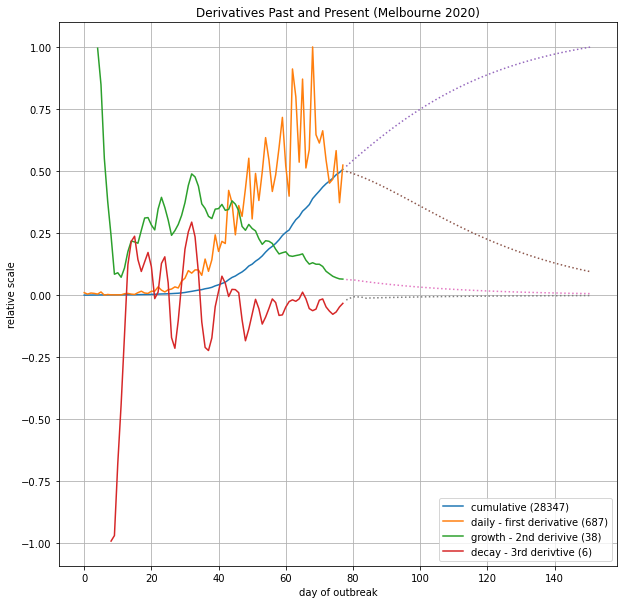

In [14]:
ax=plot_derivatives(vic_projection, len(vic_partial), dataset="Melbourne 2020")
ax.figure.savefig(f'archive/{SAMPLE_DATE}/derivatives-melbourne-partial.png')

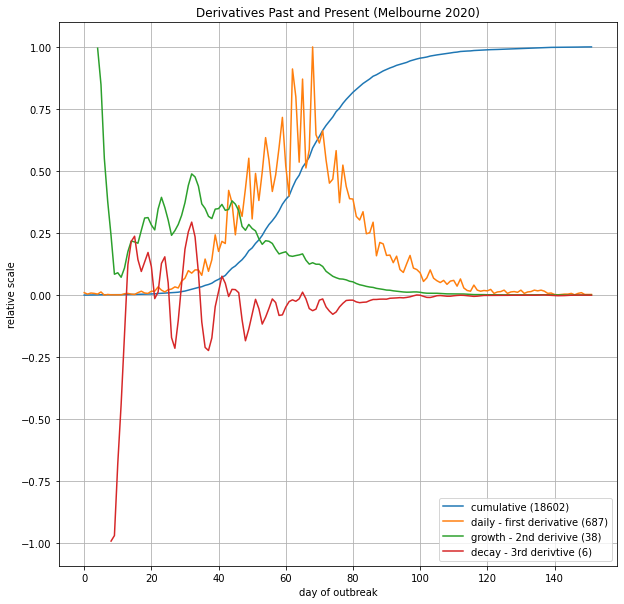

In [15]:
ax=plot_derivatives(vic_outbreak, None, dataset="Melbourne 2020")
ax.figure.savefig(f'archive/{SAMPLE_DATE}/derivatives-melbourne-full.png')

In [16]:
bondi[[
    "cumulative", 
    "total", 
    "ols-growth-rate", 
    "ols-growth-rate-decay",  
    "doubling-period",
    "one-day-error", 
    "one-day-projection-cumulative", 
    "one-day-projection-total", 
]].tail(15)

,cumulative,total,ols-growth-rate,ols-growth-rate-decay,doubling-period,one-day-error,one-day-projection-cumulative,one-day-projection-total
23,497.0,49.0,10.454440,0.219720,6.971001,8.0,549.0,52.0
24,574.0,77.0,11.674573,0.777650,6.277435,25.0,641.0,67.0
25,686.0,112.0,14.016368,1.217257,5.284269,45.0,782.0,96.0
26,775.0,89.0,15.239539,1.417639,4.886731,-7.0,893.0,118.0
27,872.0,97.0,15.311070,1.181773,4.865446,-21.0,1006.0,134.0
28,937.0,65.0,12.975631,0.345170,5.681443,-69.0,1059.0,122.0
29,1034.0,97.0,10.632588,-0.797755,6.859820,-25.0,1144.0,110.0
30,1145.0,111.0,9.976821,-1.339994,7.288657,1.0,1259.0,114.0
31,1250.0,105.0,9.644107,-1.268781,7.528518,-9.0,1371.0,121.0
32,1348.0,98.0,9.604657,-0.693182,7.558059,-23.0,1477.0,129.0
